# Pruebas de Positional Encoding

In [34]:
%load_ext autoreload
%autoreload 2

import os
import sys
project_path = os.path.abspath('..')
sys.path.insert(1, project_path)

import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable

import matplotlib.pyplot as plt

from src.data.curve_generator import *
from src.visualization.plots import plot_periodic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Datos de prueba

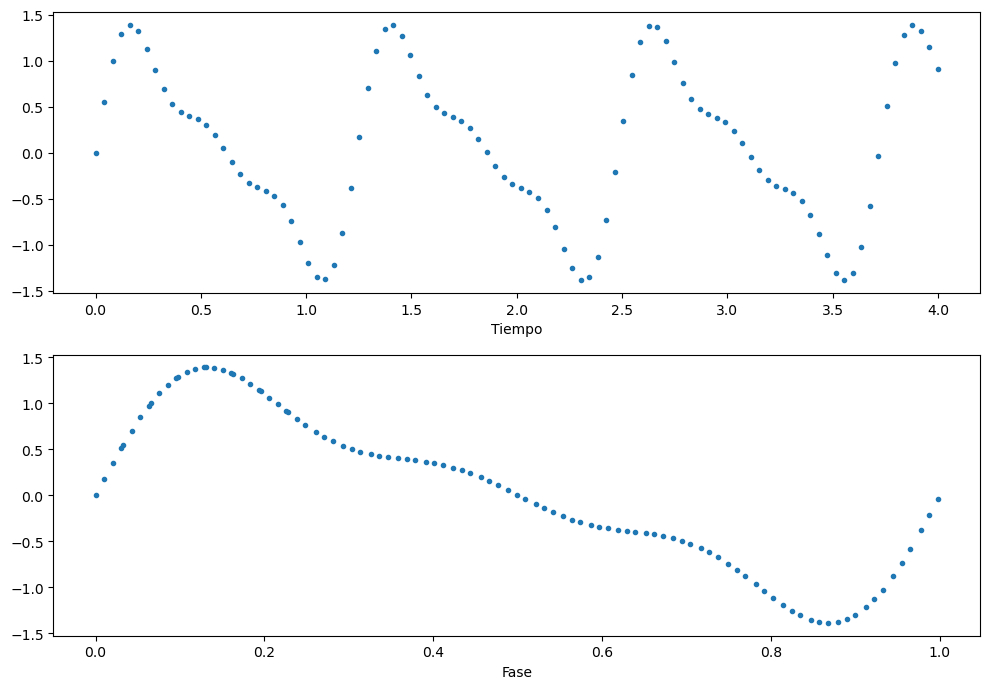

In [35]:
P = 1.24

mjd, mag = random_periodic_sin_mix(period=P, s_noise=0, irregular=False)

fig, ax = plt.subplots(2, figsize=(10,7), tight_layout=True)
plot_periodic(mjd, mag, P, ax)

## Positional Encodig (original)

In [36]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

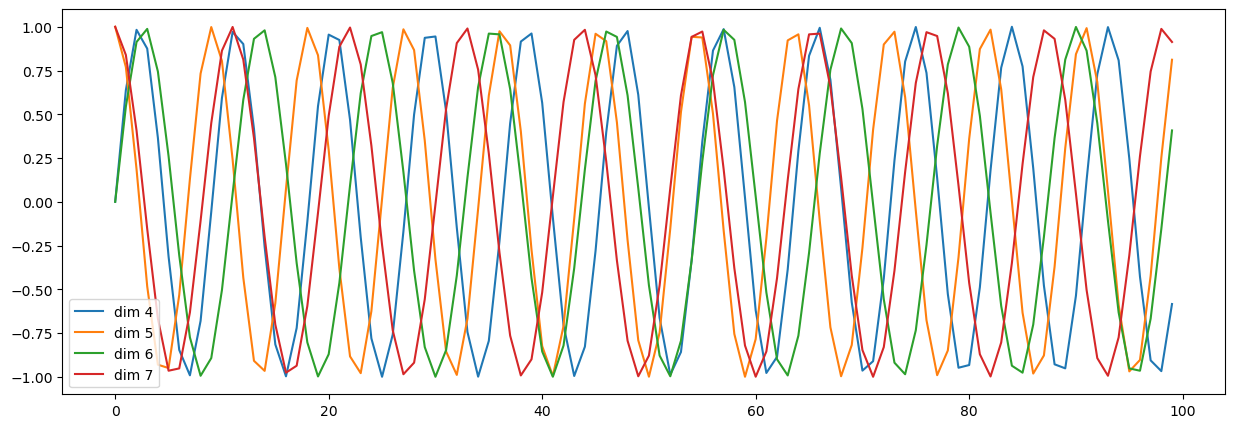

In [39]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

## Positional Encodig (Sousa)